In [2]:
# The following allows finding data directory based on the config in ~/.tap.ini
import sys
sys.path.append("../../scripts")
import dw_tap_data 
# After 3 lines a above data directory can be references using: dw_tap_data.path

sys.path.append("../../notebooks/validation")

import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
import glob
from dw_tap.data_processing import _LatLon_To_XY, filter_obstacles
from dw_tap.obstacles import AllObstacles

from pyproj import Transformer
from shapely.geometry import LineString, Polygon, MultiPolygon, Point, MultiPoint, shape
from shapely.ops import split, nearest_points
import fiona
import perera
import pickle
import common
import site_index_oe

import warnings
# Hide all warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

obstacle_data_dir = os.path.join(dw_tap_data.path, "01 One Energy Turbine Data/3dbuildings_geojson")

index = site_index_oe.SiteIndexOE()

tid = 'p1w1'
wind_source = "wtk"
obstacle_mode = "treesasbldgs"

wtk_df = pd.read_csv(os.path.join(dw_tap_data.path, "01 One Energy Turbine Data/wtk_tp.csv.bz2"))

# Create dict with dataframes that correspond to selected tid's
dfs_by_tid = {}
dfs_by_tid[tid] = wtk_df[wtk_df["tid"] == tid].reset_index(drop=True)

atmospheric_input = dfs_by_tid
display(atmospheric_input)

obs = AllObstacles(data_dir=dw_tap_data.path, types=["oneenergy"], debug=False)
obs_subset = obs.get("oneenergy", tid, obstacle_mode)

pid = tid[:2]

display(obs_subset)

dest_file = "%s/%s_epsg3740.json" % (obstacle_data_dir, tid)
obs_subset.to_crs(3740).to_file(dest_file, driver="GeoJSON", index=False)

transformer = Transformer.from_crs("epsg:4326", "epsg:3740")
buildings = fiona.open("%s/%s_epsg3740.json" % (obstacle_data_dir, tid))

features = {"treesasbldgs": {}}

row = index.lookup_by_tid(tid)
lat = row["Latitude"]
lon = row["Longitude"]
lat,lon = transformer.transform(lat,lon)
point = Point(lat,lon)
features["treesasbldgs"][tid] = perera.calculate_perera_features(point,buildings)

#pickle.dump( features["treesasbldgs"], open( "%s/%s_perera_treesasbldgs.p" % (obstacle_data_dir, tid), "wb" ) )

atmospheric_input[tid]["sector"] = common.sectorize(atmospheric_input[tid]["ws"])

atmospheric_input[tid]["ws-adjusted"] = \
    atmospheric_input[tid][["tid","sector","ws"]].\
    apply(perera.perera,axis=1,args=(features["treesasbldgs"],))

atmospheric_input[tid]["ws-adjusted-2"] = \
    atmospheric_input[tid][["tid","sector","ws"]].\
    apply(perera.perera2,axis=1,args=(features["treesasbldgs"],))

atmospheric_input[tid]["ws-adjusted-3"] = \
    atmospheric_input[tid][["tid","sector","ws"]].\
    apply(perera.perera3,axis=1,args=(features["treesasbldgs"],))

display(atmospheric_input[tid])

{'p1w1':                   datetime         ws          wd        temp          pres  \
 0      2007-01-01 00:00:00  11.429972  160.344914  285.184784  95416.112667   
 1      2007-01-01 01:00:00  12.601066  170.244337  285.679199  95341.990290   
 2      2007-01-01 02:00:00  11.008472  222.110030  285.239716  95438.777724   
 3      2007-01-01 03:00:00  12.665842  219.703827  284.333313  95451.063645   
 4      2007-01-01 04:00:00  11.366636  213.223690  283.002716  95438.525090   
 ...                    ...        ...         ...         ...           ...   
 61363  2013-12-31 19:00:00   8.736952  249.527098  263.843201  97044.980089   
 61364  2013-12-31 20:00:00   8.775385  248.545440  264.233795  97039.230863   
 61365  2013-12-31 21:00:00   7.789299  249.845846  264.477997  97040.533492   
 61366  2013-12-31 22:00:00   6.267355  253.119428  264.407806  97041.495217   
 61367  2013-12-31 23:00:00   5.389096  255.782739  264.355865  97071.126376   
 
        inversemoninobukhovlen

,height,geometry,feature_type,tid,site_id
0,37.520020,"POLYGON ((-83.64808 41.09416, -83.64808 41.093...",building,p1w1,p1
1,11.819946,"POLYGON ((-83.65009 41.08993, -83.65009 41.090...",building,p1w1,p1
2,108.609985,"POLYGON ((-83.64166 41.08966, -83.64169 41.089...",building,p1w1,p1
3,16.669983,"POLYGON ((-83.65089 41.08738, -83.65075 41.087...",building,p1w1,p1
4,16.190002,"POLYGON ((-83.64060 41.08607, -83.64033 41.086...",building,p1w1,p1
...,...,...,...,...,...
423,54.620056,"POLYGON ((-83.64352 41.08273, -83.64340 41.082...",tree,p1w1,p1
424,61.390015,"POLYGON ((-83.64506 41.08245, -83.64507 41.082...",tree,p1w1,p1
425,14.789978,"POLYGON ((-83.64512 41.08261, -83.64511 41.082...",tree,p1w1,p1
426,7.080017,"POLYGON ((-83.64514 41.08275, -83.64512 41.082...",tree,p1w1,p1


,datetime,ws,wd,temp,pres,inversemoninobukhovlength_2m,tid,packet_date,sector,ws-adjusted,ws-adjusted-2,ws-adjusted-3
0,2007-01-01 00:00:00,11.429972,160.344914,285.184784,95416.112667,0.004876,p1w1,2007-01-01 00:00:00+00:00,10.0,6.956180,11.291265,11.358040
1,2007-01-01 01:00:00,12.601066,170.244337,285.679199,95341.990290,0.003894,p1w1,2007-01-01 01:00:00+00:00,10.0,7.668897,12.448147,12.521763
2,2007-01-01 02:00:00,11.008472,222.110030,285.239716,95438.777724,0.007028,p1w1,2007-01-01 02:00:00+00:00,10.0,6.699658,10.874880,10.939192
3,2007-01-01 03:00:00,12.665842,219.703827,284.333313,95451.063645,0.013516,p1w1,2007-01-01 03:00:00+00:00,10.0,7.708319,12.512137,12.586131
4,2007-01-01 04:00:00,11.366636,213.223690,283.002716,95438.525090,0.019596,p1w1,2007-01-01 04:00:00+00:00,10.0,6.917634,11.228697,11.295102
...,...,...,...,...,...,...,...,...,...,...,...,...
61363,2013-12-31 19:00:00,8.736952,249.527098,263.843201,97044.980089,-0.013917,p1w1,2013-12-31 19:00:00+00:00,0.0,8.736952,8.736952,8.736952
61364,2013-12-31 20:00:00,8.775385,248.545440,264.233795,97039.230863,-0.009694,p1w1,2013-12-31 20:00:00+00:00,0.0,8.775385,8.775385,8.775385
61365,2013-12-31 21:00:00,7.789299,249.845846,264.477997,97040.533492,-0.004875,p1w1,2013-12-31 21:00:00+00:00,0.0,7.789299,7.789299,7.789299
61366,2013-12-31 22:00:00,6.267355,253.119428,264.407806,97041.495217,0.009616,p1w1,2013-12-31 22:00:00+00:00,0.0,6.267355,6.267355,6.267355


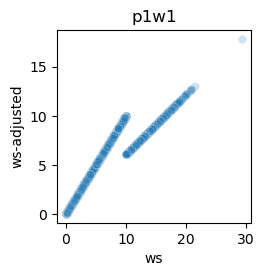

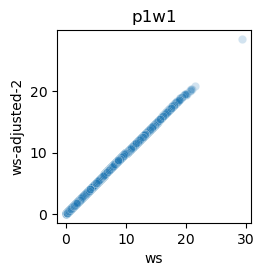

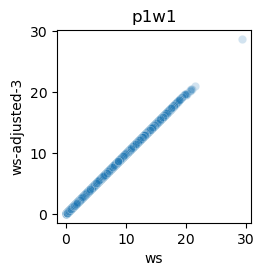

In [4]:
df = atmospheric_input[tid]
fig = plt.gcf()
fig.set_size_inches(2.5,2.5)
sns.scatterplot(x=df["ws"], \
                y=df["ws-adjusted"], alpha=0.2).set(title=tid);
plt.show()

fig = plt.gcf()
fig.set_size_inches(2.5,2.5)
sns.scatterplot(x=df["ws"], \
                y=df["ws-adjusted-2"], alpha=0.2).set(title=tid);
plt.show()

fig = plt.gcf()
fig.set_size_inches(2.5,2.5)
sns.scatterplot(x=df["ws"], \
                y=df["ws-adjusted-3"], alpha=0.2).set(title=tid);
plt.show()